In [1]:
%load_ext autoreload
%autoreload 2

In [459]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cbook as cbook

from hydramuscle.model.force_encoder_ecto import ForceEncoderEcto
from hydramuscle.model.force_encoder_endo import ForceEncoderEndo
import hydramuscle.utils.utils as utils

import cv2
from tqdm import tqdm

import cmocean

In [439]:
dpi = 100
LABELSIZE = 15*dpi/100
FONTSIZE = 20*dpi/100
PANELSIZE = 30*dpi/100
LEGENDSIZE = 30*dpi/100

NUMX = 30
NUMY = 60

stim_fast = np.array([100.0, 109.5, 115.5, 118.5, 122.25, 125.75, 129.0, 132.5, 136.0, 143.25,
             208.0, 209.75, 217.75, 223.75, 227.25, 230.25, 233.75, 237.5, 242.0, 249.75,
             339.75, 347.25, 352.5, 356.25, 359.75, 363.0, 366.25, 370.0, 375.25,
             462.25, 471.5, 476.75, 480.5, 483.75, 486.75, 490.25, 493.75, 497.5, 502.75])
stim_fast -= 100

init1 = 0
init2 = 108
init3 = 239.75
init4 = 362.25
stim_slow = np.array([init1+20, init2+20, init3+20, init4+20])

In [333]:
# Load fluo trace
fluo = pd.read_csv('../results/data/fluorescence/total_fluo_Pre_Bisect_40x_4fps_ex3.csv').values
fluo = fluo[1086:3006]
fluo = utils.normalize(fluo)

# Load calcium data
filename = "2020-09-28-23-41-19-017767"
calcium = pd.read_hdf("../results/data/calcium/" + filename + ".h5")
calcium = calcium.values.reshape(len(calcium), 60, 60)
ca_ecto_full = calcium[:, :30, :]
ca_endo_full = calcium[:, 30:, :]
calcium = calcium[5000:]
ca_ecto = calcium[:, :30, :]
ca_endo = calcium[:, 30:, :]

# Encode stress
fo_ecto = utils.encode_force_2d(ForceEncoderEcto, ca_ecto_full, 30, 60, 0.02, save_interval=1)[5000:]
fo_endo = utils.encode_force_2d(ForceEncoderEndo, ca_endo_full, 30, 60, 0.02, save_interval=1)[5000:]
stress = np.concatenate((fo_ecto, fo_endo), axis=1)

# Load images
images = [None for i in range(251)]
images_path = '/home/hengji/Data/hydramuscle/hydramuscle/results/figures/frames/frames/'
for image_name in os.listdir(images_path):
    with cbook.get_sample_data(images_path + image_name) as image_file:
        index_string = image_name[3:6].lstrip('0')
        index = int(index_string) if index_string else 0
        images[index] = plt.imread(image_file)
        
# Load lengths
PREFIX = 'coords_017767_rlx60_'
lengths_1 = utils.length_of_model("../results/data/length/"+PREFIX+"100-350.txt", display=False, totaltime=100)
lengths_2 = utils.length_of_model("../results/data/length/"+PREFIX+"350-600.txt", display=False, totaltime=100)
lengths = lengths_1 + lengths_2
lengths = lengths[:4750]
real_lengths = pd.read_csv("../results/data/length/lengths_Pre_Bisect_40x_4fps_ex3.csv").values
real_lengths = [x*(0.227/40) for x in real_lengths]
real_lengths = utils.filter_abnormal(real_lengths)
real_lengths = real_lengths[1100:3000]

100%|██████████| 30000/30000 [00:04<00:00, 6520.99it/s]


In [261]:
def draw_fluo_trace(ax, fluo, t):

    lns1 = ax.plot(np.arange(-5, t+0.25, 0.25), fluo[:int((t+5.25)/0.25)], 
                   'gray', linewidth=3, label='fluorescence')
    ax.set_xlim(-5, 250)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('time(s)', fontsize=LABELSIZE, labelpad=1)
    ax.set_ylabel('fluorescence(a.u.)', fontsize=LABELSIZE)
    ax.set_title('Experimentally recorded whole-frame GCaMP fluorescence of neurons', 
                 fontsize=FONTSIZE, fontweight="bold")
    
    for stim in stim_fast[stim_fast <= t]:
        lns2 = ax.plot(stim, fluo[int((stim+5)/0.25)], marker="*", color='b', 
                       markersize=10, label='firing times', linestyle='None')

In [421]:
def draw_stim_times(ax, t):
    
    for j, moment in enumerate(stim_fast[stim_fast <= t]):
        ax.vlines(moment, 0, 1, color='darkgreen', linewidth=1)

    for j, moment in enumerate(stim_slow[stim_slow <= t]):
        ax.vlines(moment, 0, 1, color='r', alpha=0.5, linewidth=4)
    
    ax.plot(np.NaN, np.NaN, '-', color='darkgreen', label='fast')
    ax.plot(np.NaN, np.NaN, '-', color='r', label='slow')
    
    ax.set_xlim(-5, 250)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel('time(s)', fontsize=LABELSIZE, labelpad=1)
    ax.legend(fontsize=LEGENDSIZE)
    ax.set_title('Stimulation times of fast and slow pathways', 
                 fontsize=FONTSIZE, fontweight="bold")

In [422]:
def draw_data_pattern(ax, data, t, colormap):
    
    im = ax.imshow(data[int(t/0.02)].T, 
              cmap=colormap, vmin=0, vmax=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(round(t, 2)) + 's', fontsize=40*dpi/100)
    
    ax.axhline(-1, 0, 0.5, color='green', linewidth=10)
    ax.axhline(NUMY, 0, 0.5, color='green', linewidth=10)
    ax.axvline(-0.5, 0, 1, color='green', linewidth=10)
    ax.axvline(NUMX-0.25, 0, 1, color='green', linewidth=5)
    
    ax.axhline(-1, 0.52, 1, color='red', linewidth=10)
    ax.axhline(NUMY, 0.52, 1, color='red', linewidth=10)
    ax.axvline(NUMX+0.5, 0, 1, color='red', linewidth=5)
    ax.axvline(NUMX*2, 0, 1, color='red', linewidth=10)
    
    ax.set_xlim(-1, NUMX*2+0.5)
    ax.set_ylim(-1, NUMY+0.5)
    
    return im

In [423]:
def draw_behavior(ax, images, t):
    im = images[t]
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(t) + 's', fontsize=40*dpi/100)

In [424]:
def draw_length(ax, real_lengths, lengths, t):
    ax.plot(np.arange(0, t+0.25, 0.25), real_lengths[:int(t/0.25)+1], linewidth=4, label='real', color='gray')
    ax.plot(np.arange(0, t+0.1, 0.1), lengths[:int(t/0.1)+1], linewidth=4, label='model', color='blue')
    ax.set_xlim(-5, 250)
    ax.set_ylim(min(min(real_lengths), min(lengths)), max(max(real_lengths), max(lengths)))
    ax.set_xlabel('time(s)', fontsize=LABELSIZE, labelpad=1)
    ax.set_ylabel('length(mm)', fontsize=LABELSIZE, labelpad=1)
    ax.legend(loc='upper right', fontsize=LEGENDSIZE)
    ax.set_title('Modeled length and experimentally measured length of a real hydra', fontsize=FONTSIZE, fontweight="bold")

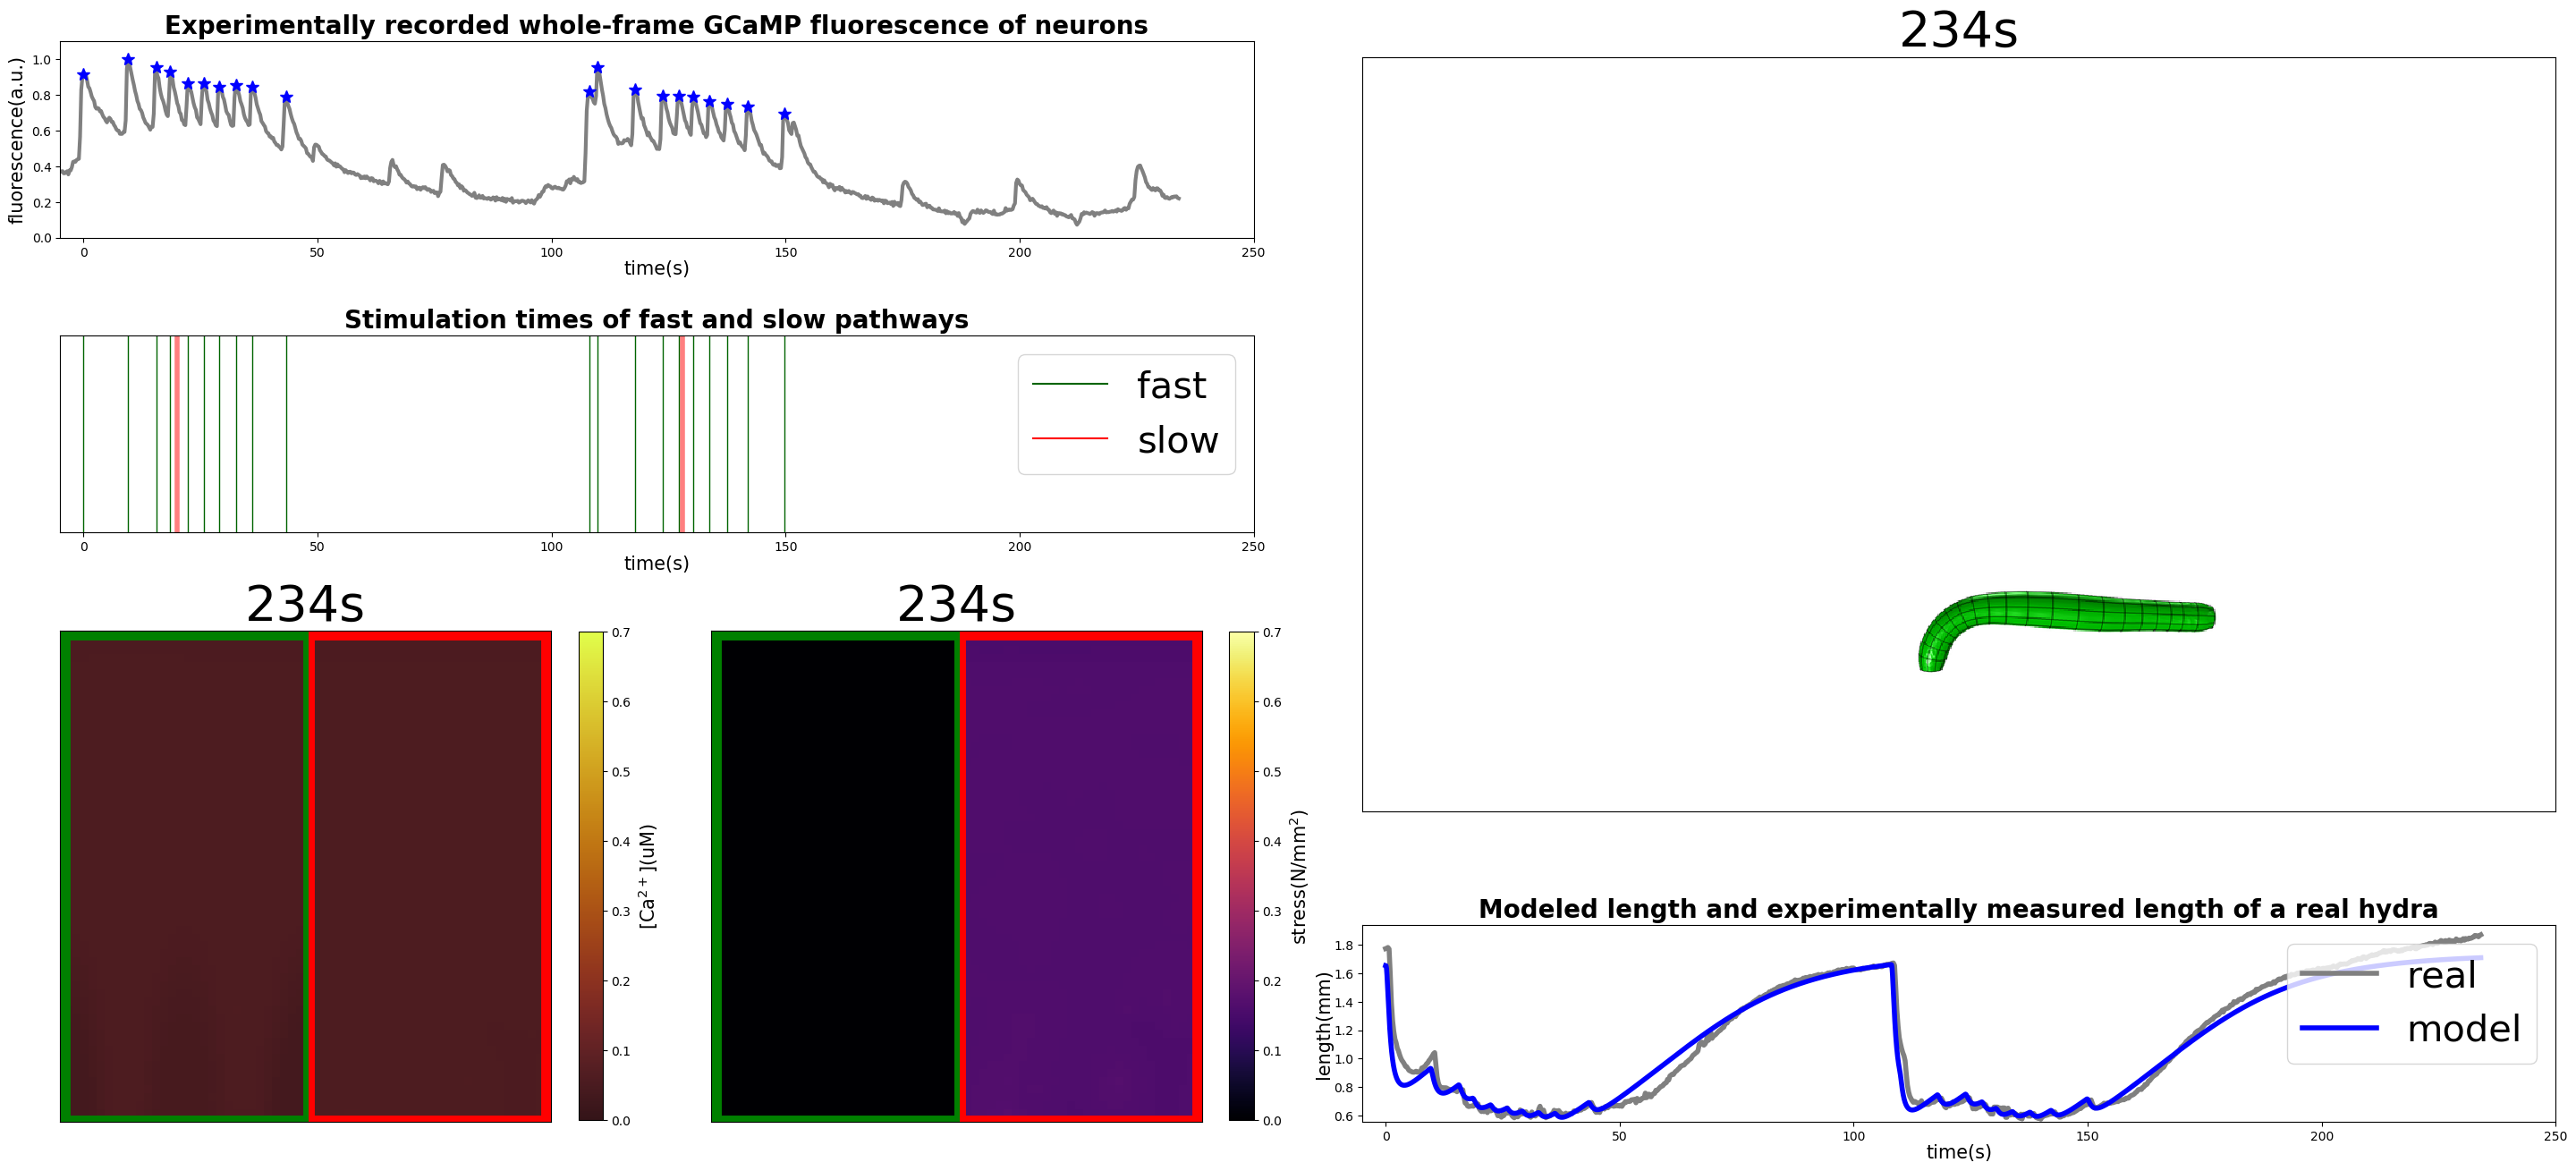

In [481]:
savepath = '../results/videos/'

fig = plt.figure(figsize=(36*dpi/100,16*dpi/100), dpi=dpi)

for t in range(235):
    
    plt.clf()

    # Add axes
    gs = gridspec.GridSpec(4, 4, height_ratios=[1, 1, 1, 1])
    gs.update(hspace=0.5)
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[1, :2])
    ax3 = fig.add_subplot(gs[2:, 0])
    ax4 = fig.add_subplot(gs[2:, 1])
    ax5 = fig.add_subplot(gs[:3, 2:])
    ax6 = fig.add_subplot(gs[3, 2:])

    # Draw
    # ax1
    draw_fluo_trace(ax1, fluo, t)
    # ax2
    draw_stim_times(ax2, t)
    # ax3
    im = draw_data_pattern(ax3, calcium, t, cmocean.cm.solar)
    cb = fig.colorbar(im, ax=ax3, fraction=0.045)
    cb.set_label('[Ca$^{2+}$](uM)', fontsize=LABELSIZE)
    # ax4
    im = draw_data_pattern(ax4, stress, t, 'inferno')
    cb = fig.colorbar(im, ax=ax4, fraction=0.045)
    cb.set_label('stress(N/mm$^2$)', fontsize=LABELSIZE)
    # ax5
    draw_behavior(ax5, images, t)
    # ax6
    draw_length(ax6, real_lengths, lengths, t)

    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.margins(0, 0)
    plt.savefig(savepath + 'frames/img' + str(t) + '.jpg', dpi=dpi)

In [482]:
# Save video
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
videoWriter = cv2.VideoWriter('/home/hengji/Data/hydramuscle/hydramuscle/results/videos/video.avi', fourcc, 20, (3600, 1600))

for iframe in tqdm(range(230)):
    frame = cv2.imread('../results/videos/frames/img' + str(iframe) + '.jpg')
    videoWriter.write(frame)
videoWriter.release()
cv2.destroyAllWindows()



  0%|          | 0/230 [00:00<?, ?it/s]

  1%|          | 2/230 [00:00<00:18, 12.12it/s]

  2%|▏         | 4/230 [00:00<00:17, 12.71it/s]

  3%|▎         | 6/230 [00:00<00:17, 13.16it/s]

  3%|▎         | 8/230 [00:00<00:16, 13.52it/s]

  4%|▍         | 10/230 [00:01<00:32,  6.81it/s]

  5%|▌         | 12/230 [00:01<00:27,  8.04it/s]

  6%|▌         | 14/230 [00:01<00:23,  9.21it/s]

  7%|▋         | 16/230 [00:01<00:20, 10.31it/s]

  8%|▊         | 18/230 [00:01<00:18, 11.24it/s]

  9%|▊         | 20/230 [00:01<00:17, 11.96it/s]

 10%|▉         | 22/230 [00:02<00:16, 12.55it/s]

 10%|█         | 24/230 [00:02<00:15, 12.98it/s]

 11%|█▏        | 26/230 [00:02<00:15, 13.34it/s]

 12%|█▏        | 28/230 [00:02<00:14, 13.55it/s]

 13%|█▎        | 30/230 [00:02<00:14, 13.76it/s]

 14%|█▍        | 32/230 [00:02<00:14, 13.86it/s]

 15%|█▍        | 34/230 [00:02<00:14, 13.88it/s]

 16%|█▌        | 36/230 [00:03<00:14, 13.85it/s]

 17%|█▋        | 38/230 [00:03<00:13, 13.87it/s]

 17%|█▋    